# Введение

In this notebook we investigate what history do test user have in train.

Test set - two next weeks after train with a small gap (1-2 days).

Conclusion:
- There a few cold start users (zero history in train)
- But there are a lot of users with a few rows of data.
- In addition to this, among those users there are cases, where data is really irrelevant - more than 2 months gap with test.

Cold start user:
- No history.
- Sparse history, given last two months of data.

### Импорты

In [1]:
import git
root = git.Repo('.', search_parent_directories=True).working_dir 

import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Данные

In [2]:
train_df = pl.scan_parquet(f'{root}/data/orders/')
test_df = pl.scan_parquet(f'{root}/data/test/')

### Колонки

- Сравним набор пользователей и item-ов.
- Сравним распределение created_timestamp.

In [3]:
train_df.collect_schema()

Schema([('item_id', Int32),
        ('user_id', Int32),
        ('created_timestamp', Datetime(time_unit='ns', time_zone=None)),
        ('last_status', String),
        ('last_status_timestamp', Datetime(time_unit='ns', time_zone=None)),
        ('created_date', String)])

In [4]:
test_df.collect_schema()

Schema([('item_id', Int32),
        ('user_id', Int32),
        ('created_timestamp', Datetime(time_unit='ns', time_zone=None)),
        ('created_date', Date)])

# Cold-Start Users And Items Counts

In [19]:
train_df.filter(pl.col('last_status') == 'canceled_orders').select((pl.col('last_status_timestamp') - pl.col('created_timestamp')).dt.total_days()).collect().to_pandas().last_status_timestamp.value_counts(normalize=True).sort_index().cumsum().head(50)

last_status_timestamp
0     0.083069
1     0.087924
2     0.109138
3     0.167063
4     0.254904
5     0.357140
6     0.458948
7     0.549834
8     0.627306
9     0.690798
10    0.742152
11    0.783298
12    0.817007
13    0.844349
14    0.866941
15    0.886563
16    0.904054
17    0.920722
18    0.935534
19    0.947763
20    0.957392
21    0.964703
22    0.970367
23    0.974807
24    0.978307
25    0.981165
26    0.983470
27    0.985440
28    0.987088
29    0.988551
30    0.989825
31    0.990916
32    0.991849
33    0.992607
34    0.993301
35    0.993915
36    0.994467
37    0.994960
38    0.995389
39    0.995811
40    0.996170
41    0.996515
42    0.996803
43    0.997056
44    0.997279
45    0.997495
46    0.997681
47    0.997855
48    0.998015
49    0.998146
Name: proportion, dtype: float64

In [5]:
test_df.select(pl.all().is_null().sum()).collect()

item_id,user_id,created_timestamp,created_date
u32,u32,u32,u32
0,0,0,0


In [6]:
def get_cold_start_matrix(col_name, status_filter=None):

    if status_filter is not None:
        train = (
            train_df
            .filter(pl.col('last_status').is_in(status_filter))
        )
    else:
        train = train_df

    train = (
        train
        .select(col_name, pl.lit(1).alias(f'{col_name}_in_train'))
        .unique()
    )
    
    count_df = (
        test_df
        .select(col_name, pl.lit(1).alias(f'{col_name}_in_test')).unique()
        .join(
            train,
            how='full',
            on=col_name
        )
        .select(f'{col_name}_in_test', f'{col_name}_in_train')
        .fill_null(0)
        .group_by(f'{col_name}_in_train', f'{col_name}_in_test')
        .agg(pl.len())
    )
    
    return count_df.collect()

In [7]:
train_df.select('last_status').unique().collect()

last_status
str
"""delivered_orders"""
"""proccesed_orders"""
"""canceled_orders"""


In [8]:
get_cold_start_matrix('user_id'), get_cold_start_matrix('item_id')

(shape: (3, 3)
 ┌──────────────────┬─────────────────┬────────┐
 │ user_id_in_train ┆ user_id_in_test ┆ len    │
 │ ---              ┆ ---             ┆ ---    │
 │ i32              ┆ i32             ┆ u32    │
 ╞══════════════════╪═════════════════╪════════╡
 │ 0                ┆ 1               ┆ 6095   │
 │ 1                ┆ 1               ┆ 275117 │
 │ 1                ┆ 0               ┆ 559020 │
 └──────────────────┴─────────────────┴────────┘,
 shape: (3, 3)
 ┌──────────────────┬─────────────────┬─────────┐
 │ item_id_in_train ┆ item_id_in_test ┆ len     │
 │ ---              ┆ ---             ┆ ---     │
 │ i32              ┆ i32             ┆ u32     │
 ╞══════════════════╪═════════════════╪═════════╡
 │ 1                ┆ 0               ┆ 4305188 │
 │ 0                ┆ 1               ┆ 1958    │
 │ 1                ┆ 1               ┆ 368575  │
 └──────────────────┴─────────────────┴─────────┘)

- Almost all test users and items are present in train dataset with some delivery histore

In [9]:
get_cold_start_matrix('user_id', ['delivered_orders']), get_cold_start_matrix('item_id', ['delivered_orders'])

(shape: (3, 3)
 ┌──────────────────┬─────────────────┬────────┐
 │ user_id_in_train ┆ user_id_in_test ┆ len    │
 │ ---              ┆ ---             ┆ ---    │
 │ i32              ┆ i32             ┆ u32    │
 ╞══════════════════╪═════════════════╪════════╡
 │ 1                ┆ 1               ┆ 271746 │
 │ 1                ┆ 0               ┆ 527703 │
 │ 0                ┆ 1               ┆ 9466   │
 └──────────────────┴─────────────────┴────────┘,
 shape: (3, 3)
 ┌──────────────────┬─────────────────┬─────────┐
 │ item_id_in_train ┆ item_id_in_test ┆ len     │
 │ ---              ┆ ---             ┆ ---     │
 │ i32              ┆ i32             ┆ u32     │
 ╞══════════════════╪═════════════════╪═════════╡
 │ 1                ┆ 1               ┆ 308863  │
 │ 0                ┆ 1               ┆ 61670   │
 │ 1                ┆ 0               ┆ 2757632 │
 └──────────────────┴─────────────────┴─────────┘)

In [10]:
get_cold_start_matrix('user_id', ['delivered_orders', 'canceled_orders']), get_cold_start_matrix('item_id', ['delivered_orders', 'canceled_orders'])

(shape: (3, 3)
 ┌──────────────────┬─────────────────┬────────┐
 │ user_id_in_train ┆ user_id_in_test ┆ len    │
 │ ---              ┆ ---             ┆ ---    │
 │ i32              ┆ i32             ┆ u32    │
 ╞══════════════════╪═════════════════╪════════╡
 │ 1                ┆ 0               ┆ 552157 │
 │ 1                ┆ 1               ┆ 274177 │
 │ 0                ┆ 1               ┆ 7035   │
 └──────────────────┴─────────────────┴────────┘,
 shape: (3, 3)
 ┌──────────────────┬─────────────────┬─────────┐
 │ item_id_in_train ┆ item_id_in_test ┆ len     │
 │ ---              ┆ ---             ┆ ---     │
 │ i32              ┆ i32             ┆ u32     │
 ╞══════════════════╪═════════════════╪═════════╡
 │ 0                ┆ 1               ┆ 11580   │
 │ 1                ┆ 0               ┆ 4121740 │
 │ 1                ┆ 1               ┆ 358953  │
 └──────────────────┴─────────────────┴─────────┘)

- Filters on last status don't change the situation drastically - almost all users have some history.
- Next: History quatily - date gap, number of interactions and so on.

# Items per user to predict

In [11]:
train_inter_counts = train_df.filter(pl.col('last_status').is_in(['delivered_orders', 'canceled_orders'])).group_by('user_id').agg(pl.len())
test_inter_counts = test_df.group_by('user_id').agg(pl.len())

test_inter_counts.select('len').collect().to_series().value_counts().sort('len', descending=False)

len,count
u32,u32
1,127044
2,62554
3,34233
4,19778
5,12470
…,…
97,1
101,1
124,1


- For some users we need to make multiple predicts for delivery status.
- Next: Number of interaction in train vs number of interaction in test.

In [12]:
df = (
    train_inter_counts
    .join(test_inter_counts, how='full', on='user_id', suffix='_test')
    .select('len', 'len_test')
    .fill_null(0)
)

df = df.collect().to_pandas()

df.shape

(833369, 2)

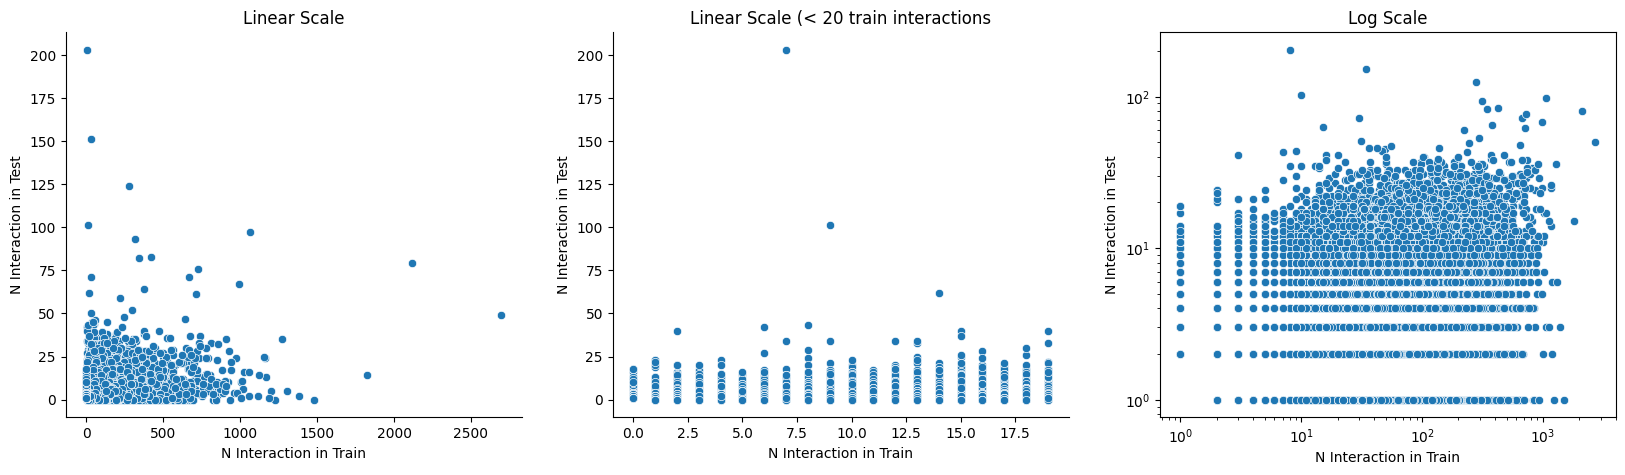

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

sns.scatterplot(data=df, x='len', y='len_test', ax=ax[0])
sns.despine(top=True, right=True, ax=ax[0])
ax[0].set_xlabel('N Interaction in Train')
ax[0].set_ylabel('N Interaction in Test')
ax[0].set_title('Linear Scale')

max_inter = 20
sns.scatterplot(data=df[df['len'] < max_inter], x='len', y='len_test', ax=ax[1])
sns.despine(top=True, right=True, ax=ax[1])
ax[1].set_xlabel('N Interaction in Train')
ax[1].set_ylabel('N Interaction in Test')
ax[1].set_title(f'Linear Scale (< {max_inter} train interactions')

sns.scatterplot(x=df['len']+1, y=df['len_test']+1, ax=ax[2])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
sns.despine(top=True, right=True, ax=ax[1])
ax[2].set_xlabel('N Interaction in Train')
ax[2].set_ylabel('N Interaction in Test')
ax[2].set_title('Log Scale')

plt.show()

- There are users that have
    - Small amount of data for train and a lot inference
    - Big amount of data for train and a few for inference
- I would suggest to take into account users that have a few train interactions as co

In [14]:
print(df[df.len_test != 0]['len'].value_counts().sort_index().head(20))

print(df[(df.len_test != 0) & (df['len'] <= 20)].shape[0], df[(df.len_test != 0) & (df['len'] > 20)].shape[0])

len
0     7035
1     6861
2     7459
3     7457
4     7606
5     7371
6     7298
7     7180
8     6915
9     6808
10    6669
11    6185
12    6046
13    5899
14    5752
15    5501
16    5266
17    5069
18    4950
19    4788
Name: count, dtype: int64
132689 148523


We think that cold-start methods will help not only with cold users, but with users with a litte interaction history (< 20 interactions).

# Date distirubition

In [15]:
train_df.select(pl.min('created_timestamp').alias('min_dt'), pl.max('created_timestamp').alias('max_dt')).collect()

min_dt,max_dt
datetime[ns],datetime[ns]
2025-01-01 00:00:01.406,2025-07-01 23:59:58.283


In [16]:
test_df.select(pl.min('created_timestamp').alias('min_dt'), pl.max('created_timestamp').alias('max_dt')).collect()

min_dt,max_dt
datetime[ns],datetime[ns]
2025-07-03 00:00:03.447,2025-07-16 23:59:58.367


- Two next weeks for test data.
- Ensemble
    - Total history models
    - Last two weeks of history model
    - Last month of history model
    - e.t.c.

In [17]:
min_test_date = test_df.group_by('user_id').agg(pl.min('created_timestamp'))
max_train_date = train_df.group_by('user_id').agg(pl.max('created_timestamp'))

dates_df = (
    max_train_date
    .join(min_test_date, how='full', on='user_id', suffix='_test')
    .select('user_id', (pl.col('created_timestamp_test') - pl.col('created_timestamp')).dt.total_days().alias('days_btw'))
)

df = train_inter_counts.join(dates_df, how='full', on='user_id').collect().to_pandas()

df.head()

,user_id,len,user_id_right,days_btw
0,3470891.0,50.0,3470891.0,23.0
1,4511381.0,7.0,4511381.0,NaN
2,1571930.0,14.0,1571930.0,17.0
3,2108160.0,51.0,2108160.0,NaN
4,596821.0,7.0,596821.0,NaN


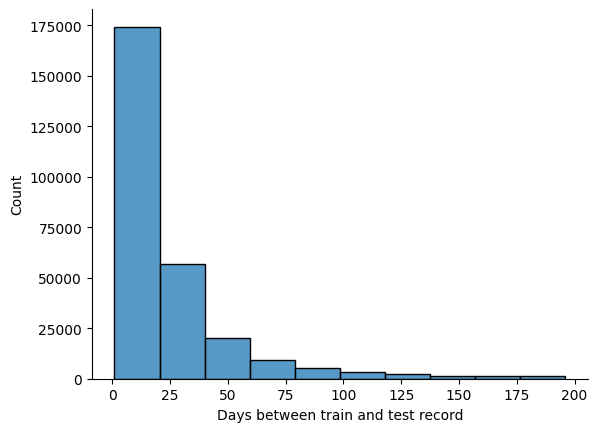

In [18]:
sns.histplot(df.days_btw, binwidth=20)
plt.xlabel('Days between train and test record')
sns.despine(top=True, right=True)

Text(0.5, 1.0, 'Data Size VS Data Relevance')

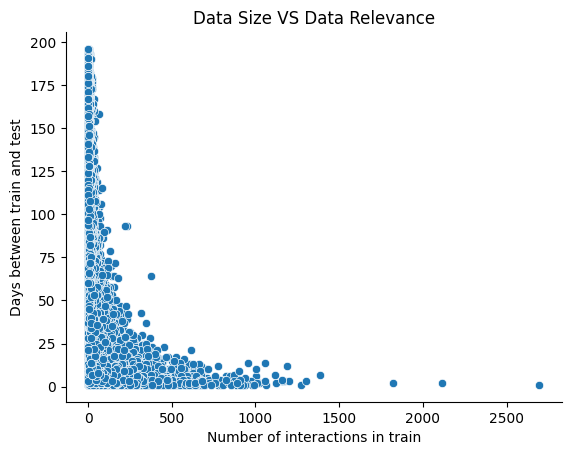

In [19]:
sns.scatterplot(data=df, x='len', y='days_btw')
plt.xlabel('len')
plt.ylabel('Days between train and test')
sns.despine(top=True, right=True)
plt.xlabel('Number of interactions in train')
plt.title('Data Size VS Data Relevance')

- There are users that have really old data in addition to small datasize.

# Same analytics but for the last 2 months (May and June)

In [20]:
train_inter_counts = (
    train_df
    .filter(
        pl.col('last_status').is_in(['delivered_orders', 'canceled_orders']) &
        (pl.col('created_timestamp') >= pl.datetime(2025, 5, 1))
    )
    .group_by('user_id')
    .agg(pl.len())
)

In [21]:
df = (
    train_inter_counts
    .join(test_inter_counts, how='full', on='user_id', suffix='_test')
    .select('len', 'len_test')
    .fill_null(0)
)

df = df.collect().to_pandas()

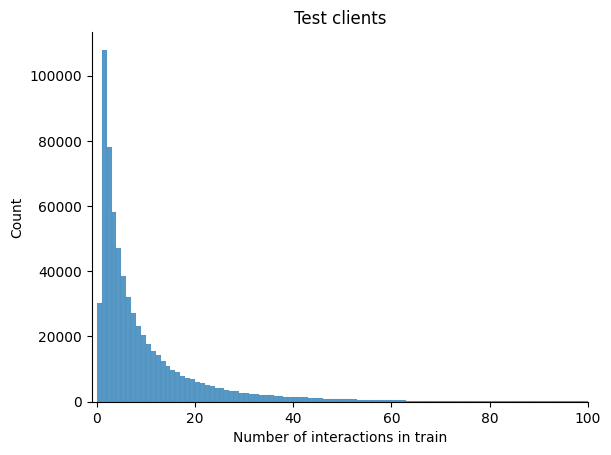

In [22]:
sns.histplot(df.loc[df['len_test'].notna(), 'len'], binwidth=1)
plt.xlim(-1, 100)
sns.despine(top=True, right=True)
plt.xlabel('Number of interactions in train')
plt.title('Test clients')
plt.show()

- A lot of cold users with sparse history given last two months.